# This notebook talks about storage types

### There are currently two types of storage that you can reserve on FABRIC:
 - regular local storage
 - NVME storage.

### This tutorial will show you how to reserve each one of them.

#### First, we need to prepare the environment. This is not the focus of this tutorial.

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

not_found=False
fabric_refresh_token=None
%store -r fabric_refresh_token

if fabric_refresh_token is None:
    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
    %store fabric_refresh_token
print("Fabric Refresh Token {}".format(fabric_refresh_token))
print("CILOGON_REFRESH_TOKEN environment variable: {}".format(os.environ['CILOGON_REFRESH_TOKEN']))

slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, 
                             refresh_token=fabric_refresh_token, project_name='all', scope='all')

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net
Fabric Refresh Token NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTGZDFMUZWGZJZMU2DANBZGE2TAYRYMRTDQMZXMMYTCMJZME2GEZB7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRVGQ4TQMJQGEYDSMRGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ
CILOGON_REFRESH_TOKEN environment variable: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTEMBRG44DOYZVMQ2DIN3BHA3DKNLBGZRGCNLEGE2TEOJSMIYWGOJ7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRVGQZTINZZG44TMOJGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ


In [2]:
try:
    id_token, refresh_token = slice_manager.refresh_tokens()
except Exception as e:
    print("Exception occurred while getting tokens:{}".format(e))

fabric_refresh_token=slice_manager.get_refresh_token()
print()
print("New Refresh Token: {}".format(fabric_refresh_token))
print()
print("Stored new Refresh Token")
%store fabric_refresh_token
print()
print()


New Refresh Token: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTGMJTME4TIMRXGJRGGZJYGJSWCZRRGEZTQYRTGM2TSNDDGFSWGZB7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRVGQ4TQMZYGEZTOMRGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ

Stored new Refresh Token
Stored 'fabric_refresh_token' (str)




# Tutorial starts here.

#### First, we can query for available resources:

In [3]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")

Status: Status.OK
Toplogy: UKY: { cpu: 6/6 , core: 188/192 , ram: 1,528/1,536 G, disk: 14,380/14,400 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		GPU-RTX6000:  GPU RTX6000 { unit: 1/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 3/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
Links:


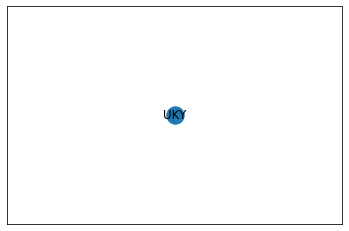

In [4]:
if status == Status.OK:
    advertised_topology.draw()

### The cell below creates a slice that contains a node. The node has 100GB of local disk storage, and an NVMe drive attached to it.

 - The regular local storage is specified in the line `cap.set_fields(core=2, ram=4, disk=100)`.The parameter "disk" is equal to 100.
 - The NVMe storage is specified in the line `n1.add_component(ctype=ComponentType.NVME, model='P4510', name='nvme1')`. More info: "Dell Express Flash NVMe P4510 1TB SFF".
 
#### Note that you need some amount of local storage when creating any node. If you specify "disk=0", some amount of local disk storage will still be assigned to you. However, you can omit the NVMe component.

In [5]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='UKY')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=4, disk=100)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='nvme1')

# # Add node
# n2 = t.add_node(name='n2', site='UKY')

# # Set Properties
# n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='JupyterSlice1', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
print("Reservations created {}".format(reservations))

Response Status Status.OK
Reservations created [{
    "graph_node_id": "7cc4189f-a1a0-4816-b7de-5353ed87b3c3",
    "lease_end": "2021-07-06 15:20:19",
    "pending_state": "None_",
    "reservation_id": "cdfa4eff-1c12-49c4-98c9-527ae6440507",
    "reservation_state": "Unknown",
    "slice_id": "898a387f-72c7-4f90-bb80-c7785d4ff881"
}]


In [6]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slivers

In [11]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
    
for s in slivers:
    status, sliver_status = slice_manager.sliver_status(slice_id=slice_id, sliver_id=s.reservation_id)
    print("Response Status {}".format(status))
    if status == Status.OK:
        print()
        print("Sliver Status {}".format(sliver_status))
        print()

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 100, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-00000194\", \"instance_parent\": \"uky-w1.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 100, \"ram\": 4}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d100\"}",
    "graph_node_id": "7cc4189f-a1a0-4816-b7de-5353ed87b3c3",
    "join_state": "NoJoin",
    "lease_end": "2021-07-06 15:20:19",
    "management_ip": "128.163.179.53",
    "name": "n1",
    "pending_state": "None_",
    "reservation_id": "cdfa4eff-1c12-49c4-98c9-527ae6440507",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "UKY",
    "slice_id": "898a387f-72c7-4f90-bb80-c7785d4ff881"
}]
Response Status Status.OK

Sliver Status {
    "allocated_capacities": "{\"core\": 2, \"disk\": 100, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-00000194\", \"instance_parent\": \"uky-w1.fabric-testbed.net\

### We can see that our node is up and running.

### Next, we are going to use paramiko to connect to the node.

In [12]:
import paramiko

key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client1 = paramiko.SSHClient()
client1.load_system_host_keys()
client1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client1.connect(slivers[0].management_ip,username='ubuntu',pkey = key)

client1

### After that, we are going to benchmark the two types of storage that we have.

#### First, let's check the available storage.

In [13]:
stdin, stdout, stderr = client1.exec_command('sudo fdisk -l')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Disk /dev/loop0: 55.48 MiB, 58159104 bytes, 113592 sectors
Units: sectors of 1 * 512 = 512 bytes
Sector size (logical/physical): 512 bytes / 512 bytes
I/O size (minimum/optimal): 512 bytes / 512 bytes


Disk /dev/loop1: 70.39 MiB, 73797632 bytes, 144136 sectors
Units: sectors of 1 * 512 = 512 bytes
Sector size (logical/physical): 512 bytes / 512 bytes
I/O size (minimum/optimal): 512 bytes / 512 bytes


Disk /dev/loop2: 32.28 MiB, 33841152 bytes, 66096 sectors
Units: sectors of 1 * 512 = 512 bytes
Sector size (logical/physical): 512 bytes / 512 bytes
I/O size (minimum/optimal): 512 bytes / 512 bytes


Disk /dev/vda: 100 GiB, 107374182400 bytes, 209715200 sectors
Units: sectors of 1 * 512 = 512 bytes
Sector size (logical/physical): 512 bytes / 512 bytes
I/O size (minimum/optimal): 512 bytes / 512 bytes
Disklabel type: gpt
Disk identifier: 936BB3ED-F3DE-4041-BF30-1DF026973DAE

Device      Start       End   Sectors  Size Type
/dev/vda1  227328 209715166 209487839 99.9G Linux filesystem
/de

<!-- We can see that we have four sections. `/dev/loop0`, `/dev/loop1`, `/dev/loop2` and `/dev/vda`. -->

### Examine the output above. Our regular storage is available at `/dev/vda`, and our NVMe storage is available at `/dev/nvme0n1`. _Ignore `/dev/loop0`, `/dev/loop1` and `/dev/loop2`._

<!-- We need to focus on `/dev/vda`. It is the storage space that we requested. We can see that it is 100 gigas in size. It says `Disk /dev/vda: 100 GiB`. -->

### We are going to run benchmarking tests on both storage types.

# 1. Benchmarking the regular local storage.

### First, we are going to benchmark the regular storage using dd. We can let the dd command write in `/tmp`. We can verify that `/tmp` is part of `/dev/vda1` by issuing the command below.

In [14]:
stdin, stdout, stderr = client1.exec_command('df /tmp')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Filesystem     1K-blocks    Used Available Use% Mounted on
/dev/vda1      101445540 1321384 100107772   2% /




### Now we issue the dd command.

In [15]:
stdin, stdout, stderr = client1.exec_command('dd if=/dev/zero of=/tmp/output bs=8k count=10000k oflag=direct status=progress; rm -f /tmp/output')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))


83815284736 bytes (84 GB, 78 GiB) copied, 917 s, 91.4 MB/s 
10240000+0 records in
10240000+0 records out
83886080000 bytes (84 GB, 78 GiB) copied, 917.759 s, 91.4 MB/s



### We can see that we get a speed of around 100 MB/s.

# 2. Benchmarking the NVMe storage.

<!-- ### Now let's run benchmarking tests on the NVMe storage. -->

In [26]:
stdin, stdout, stderr = client1.exec_command('lsblk /dev/nvme0n1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME    MAJ:MIN RM   SIZE RO TYPE MOUNTPOINT
nvme0n1 259:0    0 931.5G  0 disk 




### If we look above, we see that the disk has no partition ready for use. So we first need to make one.

### Firstly, the NVMe drive doesn't have a partition table. We need to create one.

In [29]:
stdin, stdout, stderr = client1.exec_command('sudo parted /dev/nvme0n1 mklabel gpt')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

                                                                          
Information: You may need to update /etc/fstab.




### We can check that it has been created using the command below.

In [31]:
stdin, stdout, stderr = client1.exec_command('sudo parted /dev/nvme0n1 print')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Model: Dell Express Flash NVMe P4510 1TB SFF (nvme)
Disk /dev/nvme0n1: 1000GB
Sector size (logical/physical): 512B/512B
Partition Table: gpt
Disk Flags: 

Number  Start  End  Size  File system  Name  Flags





### Next, let's print the free space in the NVMe drive in megabytes.

In [32]:
stdin, stdout, stderr = client1.exec_command('sudo parted /dev/nvme0n1 print unit MB print free')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Model: Dell Express Flash NVMe P4510 1TB SFF (nvme)
Disk /dev/nvme0n1: 1000GB
Sector size (logical/physical): 512B/512B
Partition Table: gpt
Disk Flags: 

Number  Start  End  Size  File system  Name  Flags

Model: Dell Express Flash NVMe P4510 1TB SFF (nvme)
Disk /dev/nvme0n1: 1000205MB
Sector size (logical/physical): 512B/512B
Partition Table: gpt
Disk Flags: 

Number  Start   End        Size       File system  Name  Flags
        0.02MB  1000205MB  1000205MB  Free Space





### We can see that it says `Disk /dev/nvme0n1: 1000205MB`. Next, let's create a partition that uses up this entire space.

In [33]:
stdin, stdout, stderr = client1.exec_command('sudo parted --align optimal /dev/nvme0n1 mkpart primary ext4 0% 1000205MB')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

                                                                          
34s % 2048s != 0s
Information: You may need to update /etc/fstab.




In [43]:
stdin, stdout, stderr = client1.exec_command('sudo mkfs.ext4 /dev/nvme0n1p1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Discarding device blocks:      4096/24419063 66588672/24419063145231872/24419063227545088/24419063                  done                            
Creating filesystem with 244190637 4k blocks and 61054976 inodes
Filesystem UUID: 5c5c94cd-1053-41d2-aed7-41bb20dfc58f
Superblock backups stored on blocks: 
	32768, 98304, 163840, 229376, 294912, 819200, 884736, 1605632, 2654208, 
	4096000, 7962624, 11239424, 20480000, 23887872, 71663616, 78675968, 
	102400000, 214990848

Allocating group tables:    0/745        done                            
Writing inode tables:    0/745        done                            
Creating journal (262144 blocks): done
Writing superblocks and filesystem accounting information:    0/745        done


mke2fs 1.45.5 (07-Jan-2020)



### Let's examine the partitions one more time.

In [44]:
stdin, stdout, stderr = client1.exec_command('lsblk /dev/nvme0n1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME        MAJ:MIN RM   SIZE RO TYPE MOUNTPOINT
nvme0n1     259:0    0 931.5G  0 disk 
└─nvme0n1p1 259:2    0 931.5G  0 part 




### Now we see that we have a parition that we can use.

### The next thing we need to do is to mount it.

In [46]:
stdin, stdout, stderr = client1.exec_command('mkdir /home/ubuntu/nvme_mount && sudo mount /dev/nvme0n1p1 /home/ubuntu/nvme_mount')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [47]:
stdin, stdout, stderr = client1.exec_command('df /home/ubuntu/nvme_mount')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Filesystem     1K-blocks  Used Available Use% Mounted on
/dev/nvme0n1p1 960381636 77852 911449276   1% /home/ubuntu/nvme_mount




### The NVMe drive is now mounted at `/home/ubuntu/nvme_mount`.

### So now, we can issue the same `dd` command to benchmark the NVMe drive.

In [49]:
stdin, stdout, stderr = client1.exec_command('sudo dd if=/dev/zero of=/home/ubuntu/nvme_mount/output bs=8k count=10000k oflag=direct status=progress; sudo rm -f /home/ubuntu/nvme_mount/output')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))


83865182208 bytes (84 GB, 78 GiB) copied, 211 s, 397 MB/s
10240000+0 records in
10240000+0 records out
83886080000 bytes (84 GB, 78 GiB) copied, 211.055 s, 397 MB/s



### We can see that we have a speed of around 400MB/s.